## Modelo VGPMIL

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import cv2
from time import time

def lambda_fun(xi):
    return xi / (1 + xi)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class vgpmil(object):
    def __init__(self, kernel, num_inducing=50, max_iter=10, normalize=True, verbose=False):
        self.kernel = kernel
        self.num_ind = num_inducing
        self.max_iter = max_iter
        self.normalize = normalize
        self.verbose = verbose
        self.lH = np.log(1e12)

    def initialize(self, Xtrain, InstBagLabel, Bags, Z=None, pi=None, mask=None):
        self.Ntot = len(Bags)
        self.B = len(np.unique(Bags))
        self.InstBagLabel = InstBagLabel
        self.Bags = Bags

        if self.normalize:
            self.data_mean, self.data_std = np.mean(Xtrain, 0), np.std(Xtrain, 0)
            self.data_std[self.data_std == 0] = 1.0
            Xtrain = (Xtrain - self.data_mean) / self.data_std

        if Z is not None:
            assert self.num_ind == Z.shape[0]
            self.Z = Z
        else:
            Xzeros = Xtrain[InstBagLabel == 0].astype("float32")
            Xones = Xtrain[InstBagLabel == 1].astype("float32")
            num_ind_pos = np.uint32(np.floor(self.num_ind * 0.5))
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
            nr_attempts = 10
            _, labels, Z0 = cv2.kmeans(Xzeros, self.num_ind - num_ind_pos, None, criteria, attempts=nr_attempts, flags=cv2.KMEANS_RANDOM_CENTERS)
            _, labels, Z1 = cv2.kmeans(Xones, num_ind_pos, None, criteria, attempts=nr_attempts, flags=cv2.KMEANS_RANDOM_CENTERS)
            self.Z = np.concatenate((Z0, Z1))
            if self.verbose:
                print("Inducing points are computed")

        Kzz = pairwise_kernels(self.Z, metric=self.kernel, n_jobs=-1) + np.identity(self.num_ind) * 1e-6
        self.Kzzinv = np.linalg.inv(Kzz)

        Kzx = pairwise_kernels(self.Z, Xtrain, metric=self.kernel, n_jobs=-1)
        self.KzziKzx = np.dot(self.Kzzinv, Kzx)
        self.f_var = 1 - np.einsum("ji,ji->i", Kzx, self.KzziKzx)

        self.m = np.random.randn(self.num_ind, 1)
        self.S = np.identity(self.num_ind) + np.random.randn(self.num_ind, self.num_ind) * 0.01

        if pi is not None:
            assert mask is not None, "Don't forget to provide a mask"
            self.mask = mask.copy()
            self.pi = pi.copy()
        else:
            self.pi = np.random.uniform(0, 0.1, size=self.Ntot)
            self.mask = np.ones(self.Ntot) == 1

        self.xi = np.random.randn(self.Ntot)

    def train(self, Xtrain, InstBagLabel, Bags, Z=None, pi=None, mask=None, init=True):
        if init:
            self.initialize(Xtrain, InstBagLabel, Bags, Z=Z, pi=pi, mask=mask)

        for it in range(self.max_iter):
            if self.verbose:
                print("Iter %i/%i" % (it + 1, self.max_iter))

            Lambda = 2 * lambda_fun(self.xi)
            Si = self.Kzzinv + np.dot(self.KzziKzx * Lambda, self.KzziKzx.T)
            self.S = np.linalg.inv(Si + np.identity(self.num_ind) * 1e-8)
            self.m = self.S.dot(self.KzziKzx).dot(self.pi - 0.5)

            Ef = self.KzziKzx.T.dot(self.m)
            mmTpS = np.outer(self.m, self.m) + self.S
            Eff = np.einsum("ij,ji->i", np.dot(self.KzziKzx.T, mmTpS), self.KzziKzx) + self.f_var

            Emax = np.empty(len(self.pi))
            for b in np.unique(self.Bags):
                mask = self.Bags == b
                pisub = self.pi[mask]
                m1 = np.argmax(pisub)
                tmp = np.empty(len(pisub))
                tmp.fill(pisub[m1])
                pisub[m1] = -99
                m2 = np.argmax(pisub)
                tmp[m1] = pisub[m2]
                Emax[mask] = tmp
            Emax = np.clip(Emax, 0, 1)

            mask = self.mask
            self.pi[mask] = sigmoid(Ef[mask] + self.lH * (2 * self.InstBagLabel + Emax[mask] -
                                                          2 * self.InstBagLabel[mask] * Emax - 1))

            self.xi = np.sqrt(Eff)

    def predict(self, Xtest):
        if self.normalize:
            Xtest = (Xtest - self.data_mean) / self.data_std

        Kzx = pairwise_kernels(self.Z, Xtest, metric=self.kernel, n_jobs=-1)
        KzziKzx = np.dot(self.Kzzinv, Kzx)

        return sigmoid(np.dot(KzziKzx.T, self.m))

def evaluate_model(model, X, y_true):
    y_pred_proba = model.predict(X)
    y_pred = np.round(y_pred_proba).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)


## Aplicação do VGPMIL em um conjunto de dados gerado

Inducing points are computed
Iter 1/10
Iter 2/10
Iter 3/10
Iter 4/10
Iter 5/10
Iter 6/10
Iter 7/10
Iter 8/10


<ipython-input-13-c543e3a628e8>:15: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Iter 9/10
Iter 10/10
Accuracy: 0.835
Precision: 0.9111111111111111
Recall: 0.7663551401869159
F1 Score: 0.8324873096446701
ROC AUC Score: 0.9170937594211637


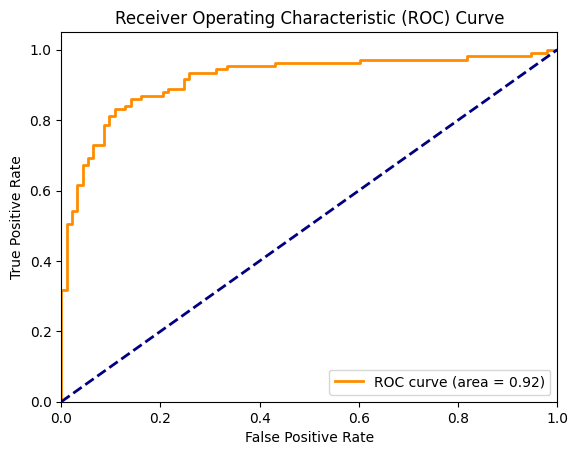

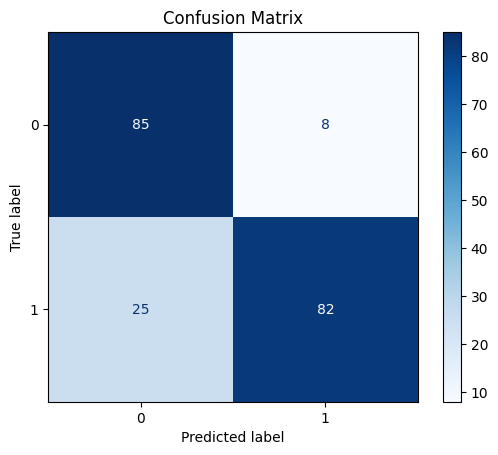

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay, confusion_matrix

# Função para plotar a curva ROC
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Função para avaliar e plotar o desempenho do modelo
def evaluate_and_plot(model, X, y_true):
    y_pred_proba = model.predict(X)
    y_pred = np.round(y_pred_proba).astype(int)

    evaluate_model(model, X, y_true)
    plot_roc_curve(y_true, y_pred_proba)
    plot_confusion_matrix(y_true, y_pred)

# Exemplo de uso com um dataset fictício
if __name__ == '__main__':
    X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    kernel = 'rbf'  # Usando a string 'rbf' para indicar o kernel RBF
    model = vgpmil(kernel, num_inducing=50, max_iter=10, verbose=True)

    model.train(X_train_scaled, y_train, np.arange(len(y_train)))

    evaluate_and_plot(model, X_test_scaled, y_test)
